In [1]:
import os
import pandas as pd
import numpy as np
import plotnine as p9

In [2]:
# list output files
file_paths = os.listdir(os.path.join('data', 'results'))
# keep only .csv files
results = [pd.read_csv(os.path.join('data', 'results', p)) for p in file_paths if p.endswith('.csv')]

In [3]:
results = pd.concat(results)

In [4]:
results['mean_auc'] = results.groupby(['reduction_name', 'dataset', 'score_key'])['auroc'].transform('mean')
results['mean_f1'] = results.groupby(['reduction_name', 'dataset', 'score_key'])['f1_score'].transform('mean')

In [5]:
results.sort_values(['reduction_name', 'dataset', 'score_key'])

,reduction_name,score_key,state,fold,auroc,tpr,fpr,f1_score,oob_score,train_split,test_split,test_classes,dataset,mean_auc,mean_f1
2,mofa,expr_prod,0,0,0.444444,[0. 0.33333333 0.33333333 0.66666667 0...,[0. 0. 0.66666667 0.66666667 1...,0.333333,0.600000,[ 1 2 3 4 7 8 9 10 11 15],[ 0 5 6 12 13 14],[0 0 0 1 1 1],carraro,0.544444,0.547249
16,mofa,expr_prod,0,1,0.666667,[0. 0.33333333 0.66666667 0.66666667 1...,[0. 0. 0. 1. 1.],0.800000,0.636364,[ 0 4 5 6 7 10 11 12 13 14 15],[1 2 3 8 9],[0 0 1 1 1],carraro,0.544444,0.547249
30,mofa,expr_prod,0,2,0.666667,[0. 0.5 0.5 1. 1. ],[0. 0. 0.66666667 0.66666667 1...,0.600000,0.545455,[ 0 1 2 3 5 6 8 9 12 13 14],[ 4 7 10 11 15],[0 0 1 0 1],carraro,0.544444,0.547249
44,mofa,expr_prod,1,0,0.722222,[0. 0.33333333 0.66666667 0.66666667 1...,[0. 0. 0. 0.66666667 1...,0.485714,0.500000,[ 1 2 4 5 8 10 11 12 13 14],[ 0 3 6 7 9 15],[0 1 0 0 1 1],carraro,0.544444,0.547249
58,mofa,expr_prod,1,1,0.000000,[0. 0. 0. 0. 1.],[0. 0.25 0.75 1. 1. ],0.600000,0.636364,[ 0 1 3 6 7 8 9 10 13 14 15],[ 2 4 5 11 12],[0 0 0 0 1],carraro,0.544444,0.547249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,tensor,magnitude_rank,3,1,0.700000,[0. 0. 0.2 0.2 0.4 0.4 0.6 1. 1. ],[0. 0.125 0.125 0.25 0.25 0.375 0.375 0.3...,0.605329,0.440000,[ 0 1 3 4 5 7 9 10 11 12 13 14 17 20 21 ...,[ 2 6 8 15 16 18 19 22 25 29 32 33 37],[0 1 0 0 0 1 0 0 1 0 1 1 0],velmeshev,0.590212,0.524523
167,tensor,magnitude_rank,3,2,0.371429,[0. 0. 0. 0.2 0.2 0.6 0.6 1. 1. ],[0. 0.14285714 0.28571429 0.28571429 0...,0.468750,0.692308,[ 0 2 6 8 10 13 15 16 17 18 19 20 21 22 24 ...,[ 1 3 4 5 7 9 11 12 14 23 26 27],[1 0 0 1 0 0 1 0 0 0 1 1],velmeshev,0.590212,0.524523
181,tensor,magnitude_rank,4,0,0.630952,[0. 0. 0.33333333 0.33333333 0...,[0. 0.14285714 0.14285714 0.28571429 0...,0.521154,0.520000,[ 0 1 2 3 4 6 7 8 10 11 12 13 14 15 17 ...,[ 5 9 16 20 21 23 24 25 27 33 34 36 37],[1 0 0 0 1 0 1 1 1 1 0 0 0],velmeshev,0.590212,0.524523
195,tensor,magnitude_rank,4,1,0.607143,[0. 0.16666667 0.16666667 0.66666667 0...,[0. 0.14285714 0.28571429 0.28571429 0...,0.615385,0.680000,[ 1 4 5 9 10 12 13 14 16 17 19 20 21 23 24 ...,[ 0 2 3 6 7 8 11 15 18 22 26 29 35],[1 0 0 1 0 0 1 0 1 0 1 0 1],velmeshev,0.590212,0.524523


In [6]:
results['score_key'].unique()

remap_dict = {'lr_means':'CellPhoneDB',
              'expr_prod':'Product',
              'lr_logfc': 'logFC',
              'lrscore': 'SingleCellSignalR',
              'lr_probs': 'CellChat',
              'magnitude_rank':'Consensus',
              'inter_score': 'scSeqComm'
              }
results['score_key'] = results['score_key'].map(remap_dict)

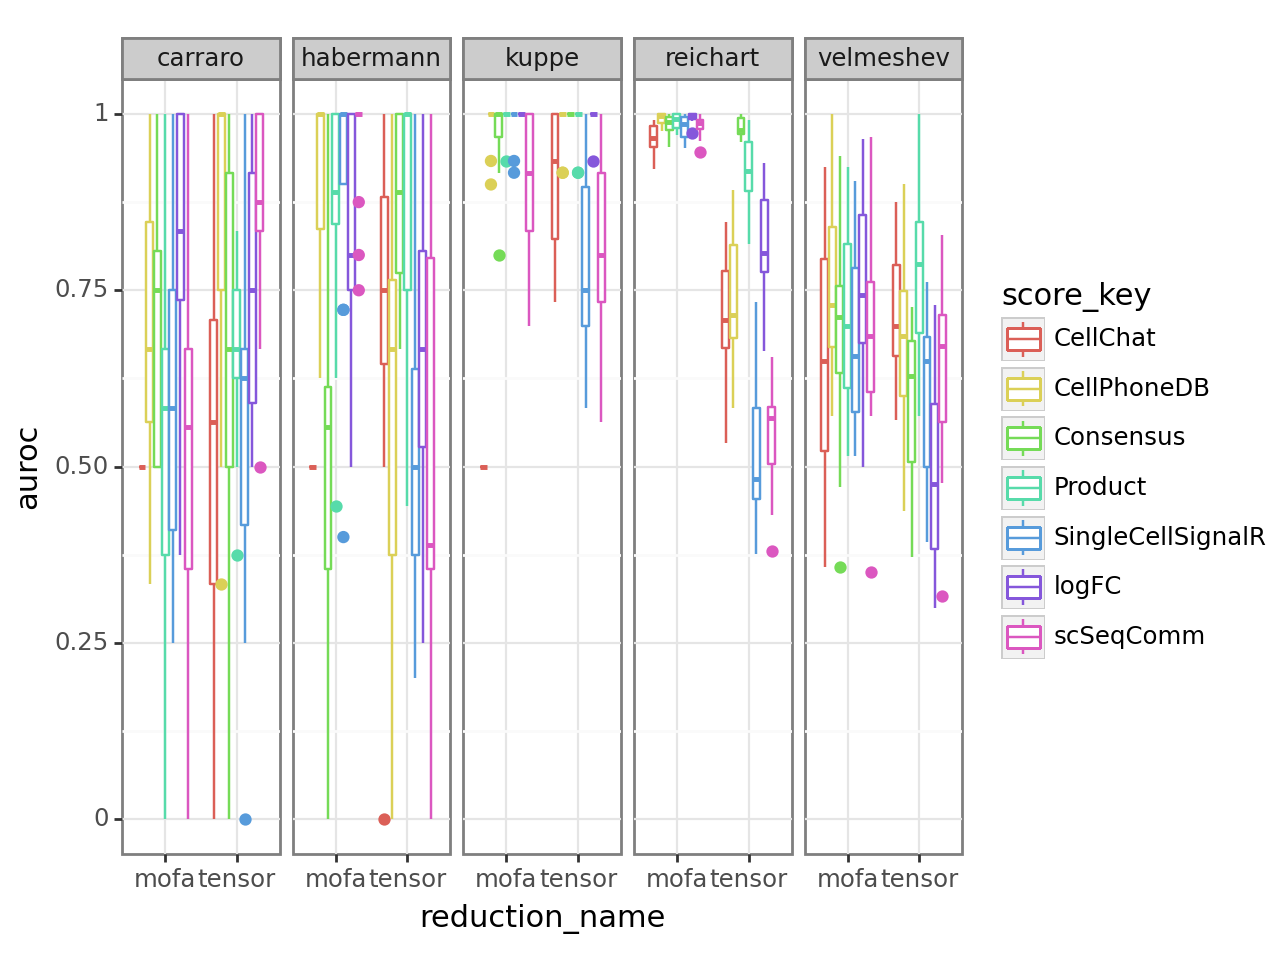

<Figure Size: (640 x 480)>

In [7]:
## plot results as boxplots by reduction_name & score_key
p9.ggplot(results, p9.aes(x='reduction_name', y='auroc', color='score_key')) + \
    p9.geom_boxplot() + \
    p9.theme_bw() + p9.facet_grid(' ~ dataset')

In [8]:
metric = 'mean_auc'

In [9]:
results = results[['reduction_name', 'score_key', 'mean_auc', 'mean_f1', 'dataset']].drop_duplicates()

In [10]:
results['rank'] = results.groupby(['dataset', 'reduction_name'])[metric].rank(ascending=False, method='average').astype('int')

In [11]:
results.head()

,reduction_name,score_key,mean_auc,mean_f1,dataset,rank
0,mofa,CellPhoneDB,0.700463,0.685820,carraro,3
1,tensor,CellPhoneDB,0.842593,0.662619,carraro,2
2,mofa,Product,0.544444,0.547249,carraro,5
3,tensor,Product,0.669444,0.420079,carraro,4
4,mofa,logFC,0.814815,0.659400,carraro,1


In [12]:
# mean rank per score
score_avg = results.groupby(['score_key', 'reduction_name'])[['rank', 'mean_auc', 'mean_f1']].mean()

In [13]:
score_avg

rank  mean_auc   mean_f1
score_key         reduction_name                          
CellChat          mofa             7.0  0.622320  0.437561
                  tensor           4.4  0.712613  0.640149
CellPhoneDB       mofa             2.4  0.869628  0.806841
                  tensor           3.4  0.762842  0.670395
Consensus         mofa             4.2  0.773473  0.641825
                  tensor           2.6  0.826610  0.727858
Product           mofa             3.4  0.822828  0.752806
                  tensor           2.4  0.842411  0.703940
SingleCellSignalR mofa             4.4  0.830735  0.729589
                  tensor           6.4  0.596185  0.532185
logFC             mofa             2.0  0.879248  0.799862
                  tensor           3.8  0.741308  0.668971
scSeqComm         mofa             4.6  0.815364  0.708480
                  tensor           4.6  0.678521  0.591709

In [14]:
score_avg['dataset'] = "Score Average"

In [15]:
## bind to results
results = pd.concat([results, score_avg.reset_index()])

In [16]:
# if dataset != 'Score Average', then None
results['rank'] = results['rank'].where(results['dataset'] == 'Score Average', None)

In [17]:
results['mean_auc'] = results['mean_auc'].round(2)
results['mean_f1'] = results['mean_f1'].round(2)

In [18]:
# to title

results['dataset'] = results['dataset'].replace({'Score Average': 'Average'})
results['dataset'] = pd.Categorical(results['dataset'], categories=['carraro', 'habermann', 'kuppe', 'velmeshev', 'reichart', 'Average'])
results['dataset'] = results['dataset'].str.title()

In [19]:
results['reduction_name'] = results['reduction_name'].replace({"mofa":"MOFA+", 'tensor':"Tensor-cell2cell"})

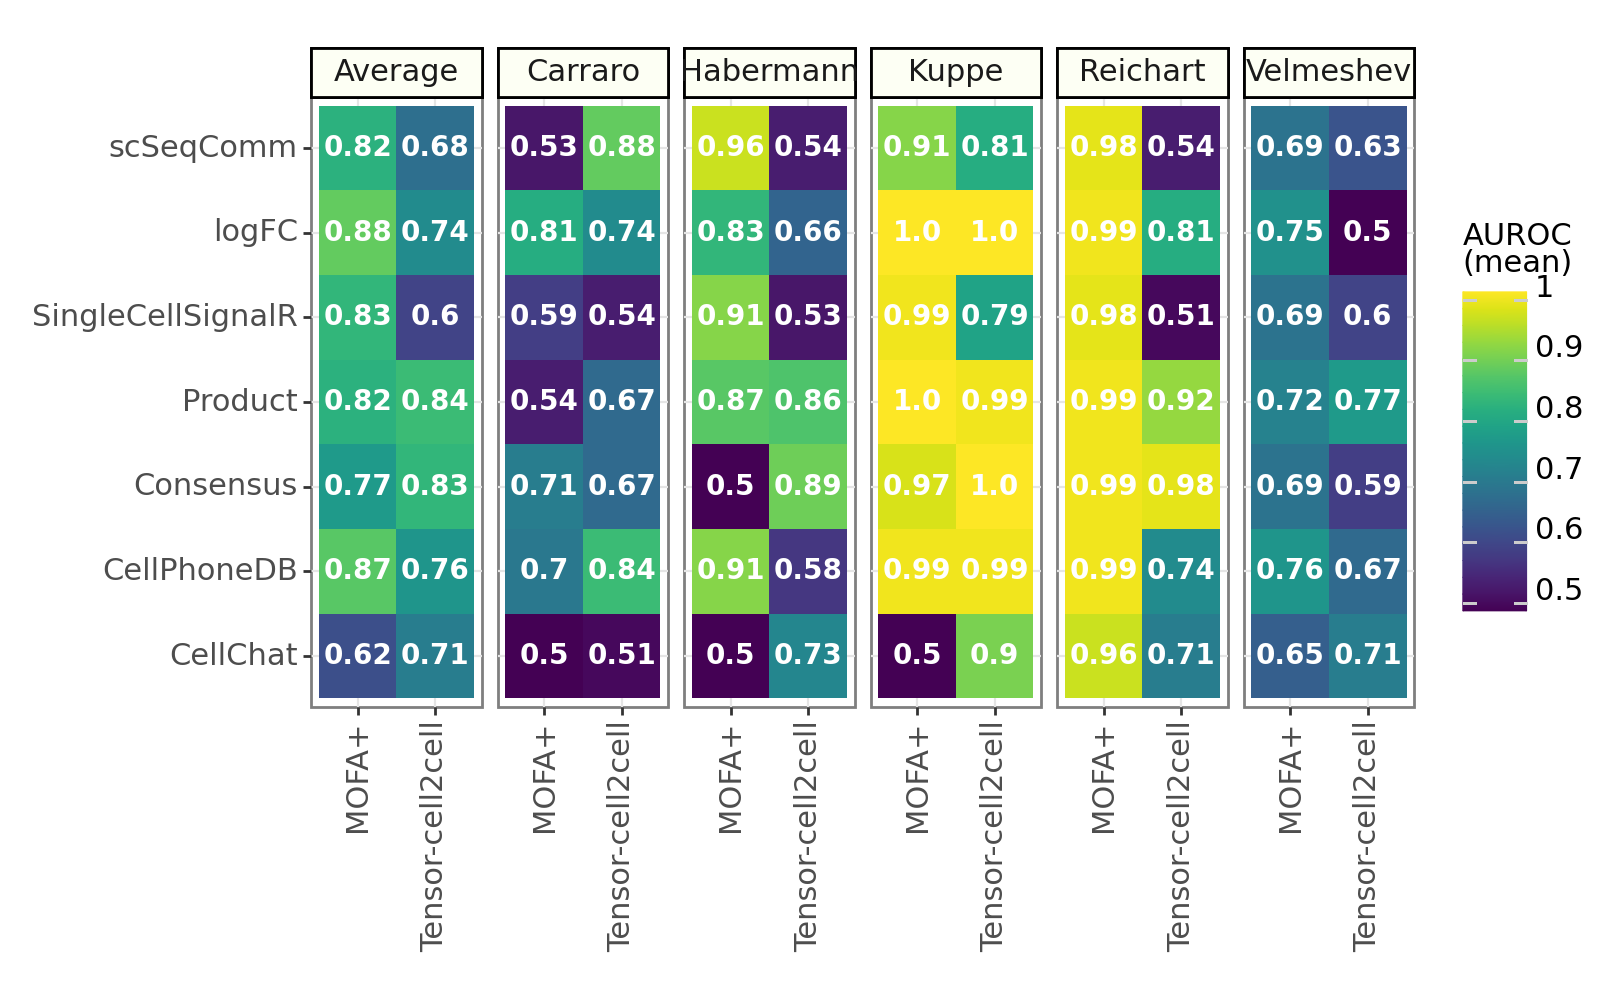

<Figure Size: (800 x 500)>

In [24]:
## mosaic plot
# order alphabetically
p9.ggplot(results, p9.aes(x='reduction_name', y='score_key', fill='mean_auc')) + \
    p9.geom_tile() + \
    p9.theme_bw(base_size=11) + \
    p9.facet_grid(' ~ dataset') + \
    p9.scale_fill_cmap(limits=(0.5, 1), cmap_name='viridis') + \
    p9.geom_text(p9.aes(label='mean_auc'), size=10, color='white', fontweight='bold') + \
    p9.theme(figure_size=(8, 5), axis_text_x=p9.element_text(angle=90, size=11),
             strip_text_x=p9.element_text(size=11),
            strip_background=p9.element_rect(colour="black", fill="#fdfff4"),
            legend_text=p9.element_text(size=11),
            axis_text_y=p9.element_text(size=11),
             ) + \
    p9.labs(x='', y='', fill='AUROC\n(mean)\n')

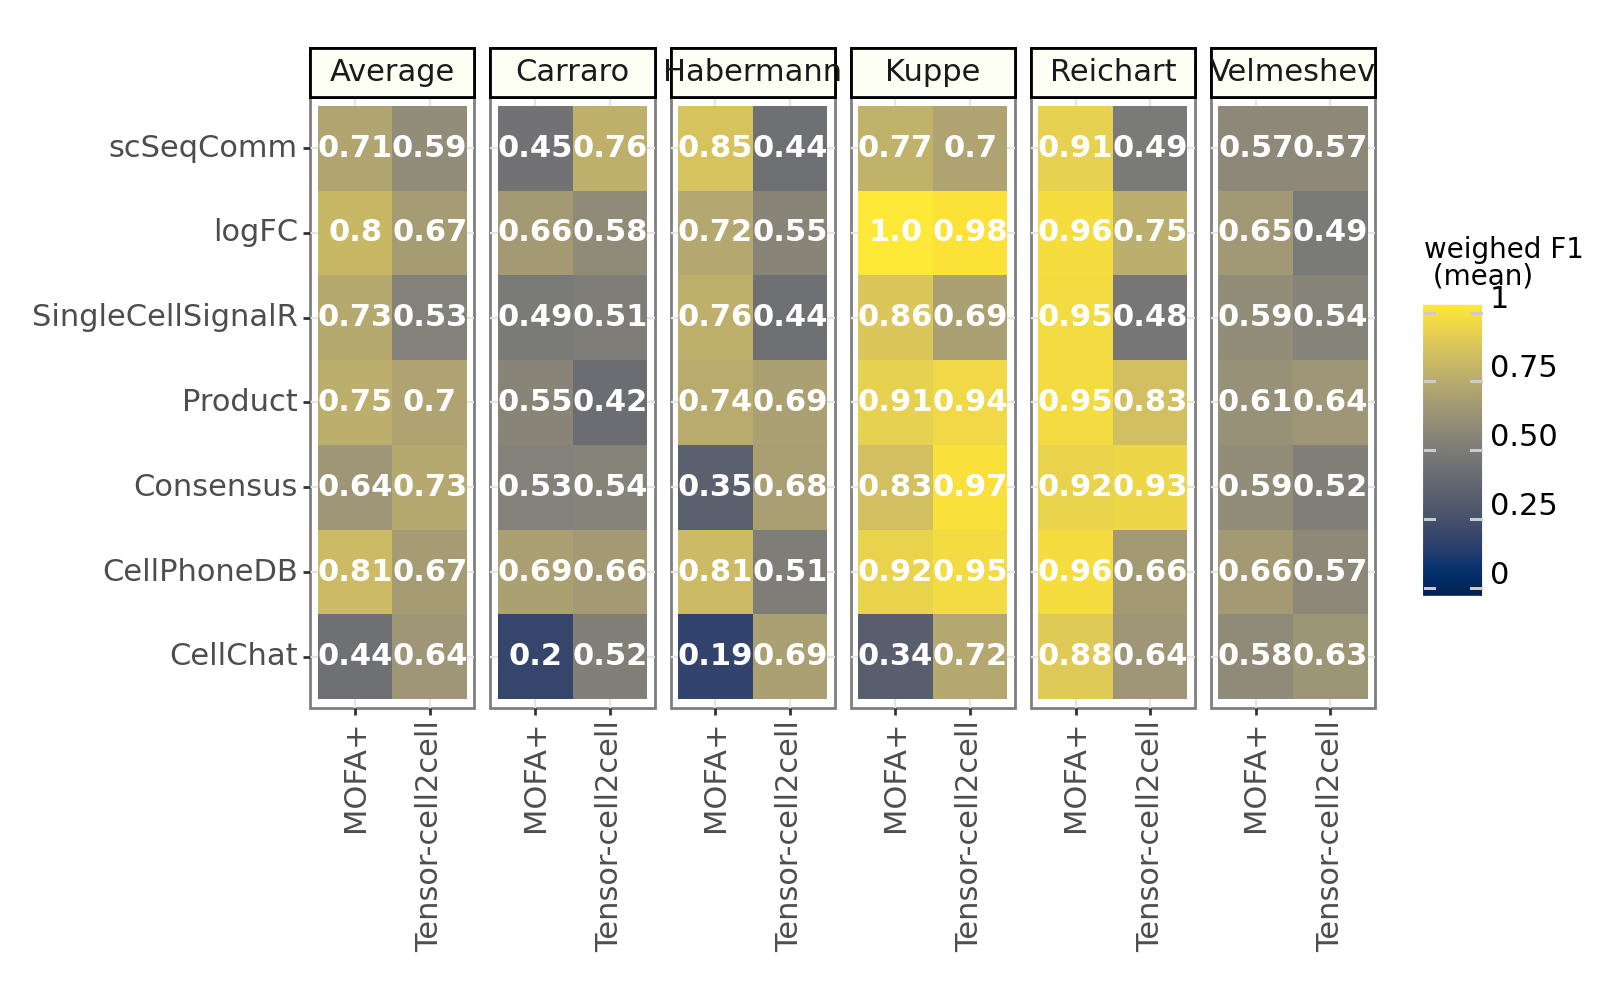

<Figure Size: (800 x 500)>

In [25]:
## mosaic plot
# order alphabetically
p9.ggplot(results, p9.aes(x='reduction_name', y='score_key', fill='mean_f1')) + \
    p9.geom_tile() + \
    p9.theme_bw(base_size=10) + \
    p9.facet_grid(' ~ dataset') + \
    p9.scale_fill_cmap(limits=(0, 1), cmap_name='cividis') + \
    p9.geom_text(p9.aes(label='mean_f1'), size=11, color='white', fontweight='bold') + \
    p9.theme(figure_size=(8, 5), axis_text_x=p9.element_text(angle=90, size=11),
             strip_text_x=p9.element_text(size=11),
            strip_background=p9.element_rect(colour="black", fill="#fdfff4"),
            legend_text=p9.element_text(size=11),
            axis_text_y=p9.element_text(size=11),
             ) + \
    p9.labs(x='', y='', fill='weighed F1\n (mean) \n')